# Supplementary Material

> **"Background-dependent selection of genetic variation in heterogeneous populations"**

> Ignacio Vázquez-García, Francisco Salinas, Jing Li, Andrej Fischer, Benjamin Barré, Johan Hallin, Anders Bergström, Elisa Alonso-Pérez, Jonas Warringer, Ville Mustonen, Gianni Liti

## Figure 3 (+ Supp. Figs.)

This IPython notebook is provided for reproduction of Figure 3 of the paper. It can be viewed by copying its URL to nbviewer and it can be run by opening it in binder.

In [11]:
# load external dependencies
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as lines
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
%matplotlib inline

import json, matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

import glob, os, re
import numpy as np
import pandas as pd # (*) Pandas for data manipulation
from scipy import stats

# load internal dependencies
import colors,plot,model,utils,config
from utils import sgd_length
from paths import * # absolute file path for data directory

## Data import

### Length distribution of homozygosity tracts

In [12]:
# load data
loh_length_df = pd.read_csv(dir_data+'seq/loh/homozygosity_length.tsv', sep='\t')
loh_length_df = loh_length_df.set_index("50kb_bin_center")
loh_length_df = loh_length_df.reindex(columns=['HU','RM','YPD'])

loh_length_df.head()

,HU,RM,YPD
50kb_bin_center,,,
25,0.731240,0.745737,0.749937
75,0.140123,0.153088,0.159649
125,0.053599,0.056461,0.053509
175,0.033691,0.021599,0.021700
225,0.013017,0.009852,0.008454


### Examples of loss-of-heterozygosity in clonal genome sequences

In [13]:
# load data
seq_loh_df = utils.load_data(dir_data+'seq/loh/seq_loh.pickle')

seq_loh_df.head()

,selection,population,set,clone,lineage,type,chr_arabic,chr_roman,start,end,length,pos,genotype,gene
0,HU,WAxNA_F12_1_HU_3,4,6,subclone A,copy_number,1,I,0,230218,NaN,0,2,
1,RM,WAxNA_F12_1_RM_3,8,2,subclone A,copy_number,1,I,0,230218,NaN,0,2,
2,RM,WAxNA_F12_1_RM_3,7,1,bulk,copy_number,1,I,0,230218,NaN,0,2,
3,RM,WAxNA_F12_1_RM_2,6,6,bulk,copy_number,1,I,0,230218,NaN,0,2,
4,RM,WAxNA_F12_1_RM_2,5,5,bulk,copy_number,1,I,0,230218,NaN,0,2,


In [14]:
# load data
seq_mut_df = utils.load_data(dir_data+'seq/de-novo/seq_de_novo_snps_indels.pickle')

seq_mut_df = seq_mut_df.rename(columns={'chrom':'chr_arabic', 'pos':'site'})
seq_mut_df['chr_roman'] = seq_mut_df['chr_arabic'].apply(utils.int_to_roman)
seq_mut_df = utils.chr_to_gw(seq_mut_df)

seq_mut_df = seq_mut_df[(seq_mut_df.time==32)&\
                        (seq_mut_df.clone!='')].reset_index(drop=True)

# remap genotype values
seq_mut_df['genotype'] = seq_mut_df['genotype'].map({'0/0': 0, '0/1': 1, '1/0': 1, '1/1': 2})

seq_mut_df['type'] = 'de novo'

seq_mut_df.head()

,ac,af,alt,an,allele,amino_acids,biotype,baseqranksum,cds_position,chr_arabic,...,clone,population,coverage,substitution,assignment,mutation_type,consequence_short,chr_roman,pos,type
0,1,0.5,[A],2,A,R/I,protein_coding,1.723,101,7,...,1,WAxNA_F12_1_HU_1,28.795032,C>A,bulk,driver,non-synonymous,VII,4595191,de novo
1,1,0.5,[C],2,NaN,NaN,NaN,-0.34,NaN,4,...,1,WAxNA_F12_1_HU_1,28.795032,A>C,bulk,passenger,NaN,IV,2849276,de novo
2,1,0.5,[A],2,A,C/F,protein_coding,-1.488,1883,10,...,1,WAxNA_F12_1_HU_1,28.795032,C>A,bulk,passenger,non-synonymous,X,5980969,de novo
3,1,0.5,[T],2,NaN,NaN,NaN,-0.653,NaN,13,...,1,WAxNA_F12_1_HU_1,28.795032,C>T,bulk,passenger,NaN,XIII,8949297,de novo
4,1,0.5,[C],2,C,C/W,protein_coding,1.674,477,13,...,1,WAxNA_F12_1_HU_1,28.795032,A>C,bulk,passenger,non-synonymous,XIII,9157827,de novo


In [15]:
columns=['selection','population','clone']
seq_mut_fixed_df = pd.merge(seq_mut_df, 
                            seq_loh_df[['selection','population','clone','set','lineage']].drop_duplicates(columns), 
                            on=columns, how='left')
seq_loh_fixed_df = pd.merge(seq_loh_df, 
                            seq_mut_df[['selection','population','clone']].drop_duplicates(columns), 
                            on=columns, how='left')

seq_dn_df = pd.concat([seq_loh_fixed_df, seq_mut_fixed_df], axis=0).reset_index(drop=True)

seq_dn_df['population'] = seq_dn_df['population']+'_T32'

seq_dn_df = pd.pivot_table(seq_dn_df, 
                           index=['selection','population','set','clone','lineage','type'], 
                           columns=['chr_arabic','chr_roman','pos','gene'])['genotype']
seq_dn_df.head()

chr_arabic                                                            1   \
chr_roman                                                              I   
pos                                                             0          
gene                                                                       
selection population           set clone lineage    type                   
HU        WAxNA_F12_1_HU_1_T32 1         subclone A consensus        NaN   
                                   1     subclone A copy_number        2   
                                                    de novo          NaN   
                                                    loh              NaN   
                               2         bulk       consensus        NaN   

chr_arabic                                                                \
chr_roman                                                                  
pos                                                             2718       
gene                                                                       
selection population           set clone lineage    type                   
HU        WAxNA_F12_1_HU_1_T32 1         subclone A consensus          2   
                                   1     subclone A copy_number      NaN   
                                                    de novo          NaN   
                                                    loh                0   
                               2         bulk       consensus          2   

chr_arabic                                                                \
chr_roman                                                                  
pos                                                             32682      
gene                                                                       
selection population           set clone lineage    type                   
HU        WAxNA_F12_1_HU_1_T32 1         subclone A consensus          2   
                                   1     subclone A copy_number      NaN   
                                                    de novo          NaN   
                                                    loh                0   
                               2         bulk       consensus        NaN   

chr_arabic                                                                \
chr_roman                                                                  
pos                                                             32947      
gene                                                                       
selection population           set clone lineage    type                   
HU        WAxNA_F12_1_HU_1_T32 1         subclone A consensus          1   
                                   1     subclone A copy_number      NaN   
                                                    de novo          NaN   
                                                    loh              NaN   
                               2         bulk       consensus        NaN   

chr_arabic                                                                \
chr_roman                                                                  
pos                                                             33867      
gene                                                                       
selection population           set clone lineage    type                   
HU        WAxNA_F12_1_HU_1_T32 1         subclone A consensus          1   
                                   1     subclone A copy_number      NaN   
                                                    de novo          NaN   
                                                    loh              NaN   
                               2         bulk       consensus        NaN   

chr_arabic                                                                \
chr_roman                                                                  
pos                                        

### Fluctuation assay

In [16]:
# read csv file containing the competition assay data
loh_fluctuation_df = pd.read_csv(dir_data+'fluctuation/fluctuation_assay.csv')

# dilution factors
loh_fluctuation_df['5-FOA+'] = loh_fluctuation_df['5FOA']*200/10
loh_fluctuation_df['Total 5-FOA'] = loh_fluctuation_df['YPD']*1000000*2/40

# rate
loh_fluctuation_df['LOH rate'] = loh_fluctuation_df['5-FOA+']/loh_fluctuation_df['Total 5-FOA']

loh_fluctuation_df = loh_fluctuation_df.groupby(['background','environment'])\
.agg([np.mean, stats.sem])

# order columns
loh_fluctuation_df = loh_fluctuation_df.ix[['WA/WA','NA/NA','WA/NA']]
loh_fluctuation_df = loh_fluctuation_df.unstack('background')

loh_fluctuation_df.head()

biological_rep                                            \
                      mean                   sem                       
background           WA/WA NA/NA WA/NA     WA/WA     NA/NA     WA/NA   
environment                                                            
HU                     2.5   2.5   2.5  0.422577  0.422577  0.422577   
RM                     2.5   2.5   2.5  0.422577  0.422577  0.422577   
YPD                    2.5   2.5   2.5  0.422577  0.422577  0.422577   

            technical_rep                          ...    Total 5-FOA  \
                     mean                   sem    ...           mean   
background          WA/WA NA/NA WA/NA     WA/WA    ...          WA/NA   
environment                                        ...                  
HU                    1.5   1.5   1.5  0.188982    ...         237500   
RM                    1.5   1.5   1.5  0.188982    ...        3662500   
YPD                   1.5   1.5   1.5  0.188982    ...        4237500   

                                                          LOH rate            \
                       sem                                    mean             
background           WA/WA          NA/NA          WA/NA     WA/WA     NA/NA   
environment                                                                    
HU            37796.447301  459910.705619   86473.571520  0.016617  0.002876   
RM           329628.782009  434293.093511  302924.731340  0.000352  0.000990   
YPD          957396.021956  316712.676795  342228.776865  0.000090  0.000209   

                                                     
                            sem                      
background      WA/NA     WA/WA     NA/NA     WA/NA  
environment                                          
HU           0.004080  0.004539  0.000354  0.000876  
RM           0.000044  0.000181  0.000114  0.000021  
YPD          0.000038  0.000022  0.000037  0.000009  

[3 rows x 42 columns]

## Figure 3 - Loss of heterozygosity

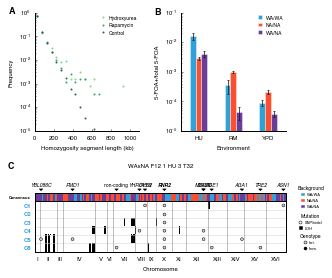

In [17]:
fig = plt.figure(figsize=(4, 4), dpi=300)

grid = gridspec.GridSpec(2, 2, height_ratios=[2, 1], hspace=0.7, wspace=0.4)

gs = {}
gs['length'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,0])
gs['fluctuation'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,1])
gs['loh'] = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=grid[1,:], hspace=0)

### top left panel ###
ax1 = plt.subplot(gs['length'][:])
ax1.text(-0.185, 1.055, 'A', transform=ax1.transAxes,
         fontsize=9, fontweight='bold', va='top', ha='right')

colors = [config.dict_selection['color'][e] for e in loh_length_df.columns]

loh_length_df.rename(columns=config.dict_selection['short_label'])\
.plot(ax=ax1, logy=True, color=colors, style='.', marker='o', ms=2., mec='none', legend=False)

utils.simple_axes(ax1)
ax1.set_xlim(0,1.1E3)
ax1.set_xlabel('Homozygosity segment length (kb)')
ax1.set_ylabel('Frequency')

ax1.legend(frameon=False, loc='upper right', 
           borderaxespad=0., prop={'size':5},
           handlelength=0.75)

### top right panel ###
ax2 = plt.subplot(gs['fluctuation'][:])
ax2.text(-0.2, 1.05, 'B', transform=ax2.transAxes,
         fontsize=9, fontweight='bold', va='top', ha='right')

colors = [config.dict_background['color'][b] for b in loh_fluctuation_df['LOH rate','mean'].columns] 
loh_fluctuation_df['LOH rate','mean'].plot(ax=ax2, kind='bar', yerr = loh_fluctuation_df['LOH rate','sem'], 
                  color=colors, legend=False,
                  error_kw=dict(ecolor='0.1', lw=.75, capsize=.75, capthick=.75))

utils.simple_axes(ax2)
ax2.set_yscale('log')
ax2.set_xlabel('Environment')
ax2.set_xticklabels(loh_fluctuation_df.index.get_level_values('environment'), minor=False, rotation=0)
ax2.set_ylabel('5-FOA+/total 5-FOA')

ax2.legend(frameon=False, loc='upper right', 
           borderaxespad=0., prop={'size':5},
           handlelength=0.75)

### bottom panel ###
ax3 = plt.subplot(gs['loh'][:1])

# make a color map of fixed colors
cmap = mpl.colors.ListedColormap([config.dict_background['color']['NA'], 
                                  config.dict_background['color']['WAxNA'], 
                                  config.dict_background['color']['WA']])
bounds=[0,1,2]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

sdn = seq_dn_df.ix['HU','WAxNA_F12_1_HU_3_T32']

indexer = [slice(None)]*len(sdn.index.names)
indexer[sdn.index.names.index('type')] = ['consensus']
gc = sdn.loc[tuple(indexer),:].dropna(axis=1, how='all')

x = gc.columns.get_level_values('pos').values
y = np.arange(len(gc.index))
data = gc.values

plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], data, 
             ax3, '', '', '', [], [], cmap=cmap, vmin=0, vmax=2)

ax3.set_title('WAxNA F12 1 HU 3 T32', fontsize=6, y=3.5)

ylabels = ['Consensus']
ax3.set_yticks(np.arange(len(ylabels)) + 0.5, minor=True)
ax3.set_yticklabels(ylabels, fontweight='bold', va='center', minor=True)

# show de novo mutations
indexer = [slice(None)]*len(sdn.index.names)
indexer[sdn.index.names.index('type')] = ['de novo']
gn_all = sdn.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
labels = gn_all.columns.get_level_values('gene')
loc = zip(gn_all.columns.get_level_values('pos'), [-.25]*gn_all.shape[1])

for l, xy in zip(labels, loc):
    trans = ax3.get_xaxis_transform() # x in data units, y in axes fraction
    ann = ax3.annotate(l, xy=xy, xytext=(0, 4), textcoords='offset points',
                       arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                       fontsize=5, style=('italic' if l!='non-coding' else 'normal'), 
                       weight=('bold' if l in ['RNR2','RNR4','FPR1','TOR1'] else 'normal'),
                       annotation_clip=False, va='bottom', ha='center')

ax4 = plt.subplot(gs['loh'][1:])

ax4.text(-0.085, 1.8, 'C', transform=ax4.transAxes,
         fontsize=9, fontweight='bold', va='top', ha='right')

# copy number
indexer = [slice(None)]*len(sdn.index.names)
indexer[sdn.index.names.index('type')] = ['copy_number']
gc = sdn.loc[tuple(indexer),:].dropna(axis=1, how='all')

x = gc.columns.get_level_values('pos').values
y = np.arange(len(gc.index.get_level_values('clone')))
data = gc.values

cmap = mpl.colors.ListedColormap(['k','w','k'])
bounds = [1,2,3]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], data, 
             ax4, '', '', '', [], [], cmap=cmap, vmin=data.min(), vmax=data.max())

# LOH
indexer = [slice(None)]*len(sdn.index.names)
indexer[sdn.index.names.index('type')] = ['loh']
gl = sdn.loc[tuple(indexer),:].dropna(axis=1, how='all')

x = gl.columns.get_level_values('pos').values
y = np.arange(len(gl.index.get_level_values('clone')))
data = gl.values

# make a color map of fixed colors
# cmap = mpl.colors.ListedColormap([config.dict_background['color']['NA'],
#                                   'w',
#                                   config.dict_background['color']['WA']])
cmap = mpl.colors.ListedColormap(['k','w','k'])
bounds = [-1,0,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], data, 
             ax4, '', '', '', [], [], cmap=cmap, vmin=data.min(), vmax=data.max())

lineage = gl.index.get_level_values('lineage').unique()[0]
ax4.tick_params(axis='y', colors=config.dict_lineages[lineage]['fill'], width=5, which='both')

# de novo mutations
indexer = [slice(None)]*len(sdn.index.names)
indexer[sdn.index.names.index('type')] = ['de novo']
gn = sdn.loc[tuple(indexer),:].dropna(axis=1, how='all')
            
for i,(k,g) in enumerate(gn.groupby(level='clone')):
    g = g.dropna(axis=1)
    x = g.columns.get_level_values('pos').values
    y = [i+.5]*len(x)
    data = g.values.flatten()
    ax4.scatter(x, y, 
                facecolors=[config.dict_genotype['color'][int(gt)] for gt in data],
                edgecolors='k', s=8, zorder=3)

ylabels = gl.index.get_level_values('clone')
ax4.set_yticks(np.arange(len(ylabels)) + 0.5)
ax4.set_yticklabels('C' + ylabels, fontweight='bold', va='center')
[ax4.axhline(g, lw=0.5, ls="-", color="lightgray") for g in np.arange(len(ylabels))]

xlabels = sgd_length.chr_start + (sgd_length.chr_end - sgd_length.chr_start)/2.
xstart = sgd_length.chr_start
ax4.set_xticks(xlabels)
ax4.set_xticklabels(sgd_length.chr_arabic.apply(utils.int_to_roman))
xgrid=[xst+1. for xst in list(set(xstart))]
[ax4.axvline(g, lw=0.5, ls="-", color="gray") for g in xgrid]

ax4.set_xlabel('Chromosome')

# set legend    
wt_artist = patches.Rectangle((0,0), width=1, height=1, color=config.dict_background['color']['WA/WA'])
hom_artist = patches.Rectangle((0,0), width=1, height=1, color=config.dict_background['color']['NA/NA'])
het_artist = patches.Rectangle((0,0), width=1, height=1, color=config.dict_background['color']['WA/NA'])

leg1 = ax3.legend([wt_artist,hom_artist,het_artist], ['WA/WA','NA/NA','WA/NA'], 
                  bbox_to_anchor=(1.1, 0.5), ncol=1,
                  frameon=False, loc='center',
                  borderaxespad=0, handlelength=0.75, 
                  title='Background', prop={'size':4})

snp_indel_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.dict_genotype['color'][0], 
                                marker='o', markersize=3, linestyle='')
loh_artist = patches.Rectangle((0,0), width=1, height=1, color='k')
    
leg2 = ax4.legend([snp_indel_artist,loh_artist], ['SNP/indel','LOH'], 
                  bbox_to_anchor=(1.1, 0.6), ncol=1,
                  frameon=False, loc='center',
                  borderaxespad=0, handlelength=0.75, 
                  title='Mutation', prop={'size':4})
    
het_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.dict_genotype['color'][1], 
                          marker='o', markersize=3, linestyle='')
hom_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.dict_genotype['color'][2],
                          marker='o', markersize=3, linestyle='')
    
leg3 = ax4.legend([het_artist,hom_artist], ['het.','hom.'], 
                  bbox_to_anchor=(1.1, 0), ncol=1,
                  frameon=False, loc='lower center',
                  borderaxespad=0, handlelength=0.75, 
                  title='Genotype', prop={'size':4})

ax4.add_artist(leg2)
        
for leg in [leg1,leg2,leg3]:
    plt.setp(leg.get_title(),fontsize=5)

# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)

fig.savefig(dir_paper+'figures/figure3/figure3.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_paper+'figures/figure3/figure3.svg', dpi=300, bbox_inches='tight')
plt.show()

Fig. 3: Pervasive loss of heterozygosity. (A) The length distribution of homozygous segments, in bins corresponding to 25-kb increments, shows evidence of long homozygosity tracts above 300 kb in hydroxyurea and rapamycin. Ancestral haploid isolates are used to compare a set of *in silico* diploid genomes to evolved diploid isolates. Only unrelated isolate backgrounds were included. (B) Background- and environment-dependent rates of loss-of-heterozygosity were measured in a fluctuation assay by loss of the *URA3* marker. 5-FOA+ colonies indicate loss of the marker. The mean number of tandard error of the mean. (C) Parental genotype (WA/WA=blue, het=white, NA/NA=red) of six related isolates from population WAxNA F12 1 HU 3, carrying a shared *RNR2* heterozygous mutation and private regions with LOH (black). Chromosome II has undergone extensive LOH in isolates C5 and C6 and these individuals have 15% faster growth rate compared to C1-C4.

## Figure S7 - Genome instability

HU WAxNA_F12_1_HU_1_T32 1
HU WAxNA_F12_1_HU_1_T32 2
HU WAxNA_F12_1_HU_2_T32 3
HU WAxNA_F12_1_HU_3_T32 4
HU WAxNA_F12_2_HU_1_T32 1
HU WAxNA_F12_2_HU_1_T32 2
HU WAxNA_F12_2_HU_2_T32 5
HU WAxNA_F12_2_HU_2_T32 6
HU WAxNA_F12_2_HU_3_T32 7
HU WAxNA_F12_2_HU_3_T32 8
RM WAxNA_F12_1_RM_1_T32 1
RM WAxNA_F12_1_RM_1_T32 2
RM WAxNA_F12_1_RM_2_T32 3
RM WAxNA_F12_1_RM_2_T32 4
RM WAxNA_F12_1_RM_2_T32 5
RM WAxNA_F12_1_RM_2_T32 6
RM WAxNA_F12_1_RM_3_T32 7
RM WAxNA_F12_1_RM_3_T32 8
RM WAxNA_F12_2_RM_1_T32 1
RM WAxNA_F12_2_RM_1_T32 2
RM WAxNA_F12_2_RM_2_T32 9
RM WAxNA_F12_2_RM_2_T32 10
RM WAxNA_F12_2_RM_2_T32 11
RM WAxNA_F12_2_RM_2_T32 12
RM WAxNA_F12_2_RM_2_T32 13
RM WAxNA_F12_2_RM_2_T32 14
RM WAxNA_F12_2_RM_3_T32 15


IOError: [Errno 2] No such file or directory: '/Users/ivg/projects/yeast-cancer-drugs/paper/science/submission/manuscript/supp/figures/figureSX_seq_loh/figureSX_seq_loh.png'

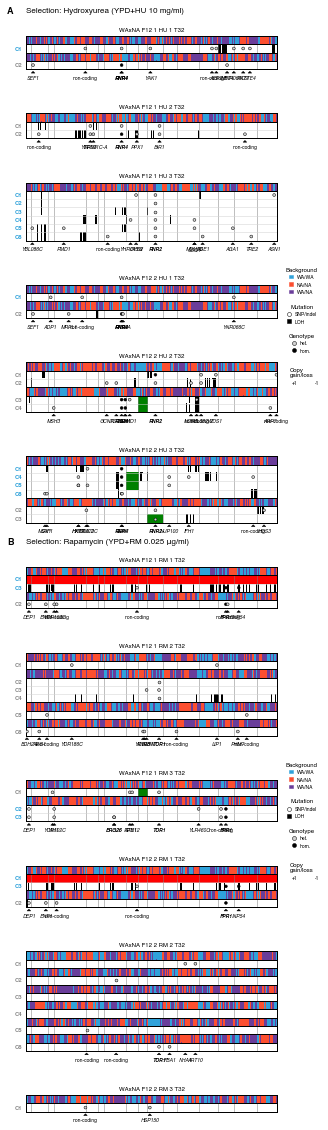

In [10]:
fig = plt.figure(figsize=(4, 18), dpi=300)

indexer = [slice(None)]*len(seq_dn_df.index.names)
indexer[seq_dn_df.index.names.index('type')] = ['consensus','loh']
seq_dn_df_sliced = seq_dn_df.loc[tuple(indexer),:].dropna(axis=1, how='all')

shape = pd.DataFrame({k: 
x.shape for k,x in seq_dn_df_sliced.groupby(level=['selection','population'])
})

ygrid = shape.ix[0].values
grid = gridspec.GridSpec(len(ygrid), 1, height_ratios=ygrid, hspace=0.9)

gs = {}

###  ###

for ii, ((e,p), sdf) in enumerate(seq_dn_df.groupby(level=['selection','population'])):

    idx = 0
    
    nrows = ygrid[ii]
    ncols = 1
    gs[(e,p)] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                                 subplot_spec=grid[ii],
                                                 hspace=0, wspace=0)
    
    for jj, (s, jdf) in enumerate(sdf.groupby(level='set')):
        
        # consensus genotype
        indexer = [slice(None)]*len(jdf.index.names)
        indexer[jdf.index.names.index('type')] = ['consensus']
        gc = jdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
        print e,p,s
        ax1 = plt.subplot(gs[(e,p)][idx:idx+len(gc)])

        idx += len(gc)
        
        # set title
        ax1.set_title(p)
        
        if len(gc) > 0:
            x = gc.columns.get_level_values('pos').values
            y = np.arange(len(gc.index))
            data = gc.values
            
            # make a color map of fixed colors
            cmap = mpl.colors.ListedColormap([config.dict_background['color']['NA'], 
                                              config.dict_background['color']['WAxNA'], 
                                              config.dict_background['color']['WA']])
            bounds = [0,1,2]
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
            
            title = (p.replace('_',' ') if jj==0 else '')
            xlabel= ''
            ylabel= ''
            xticklabels = []
            yticklabels = []
    
            plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], data, 
                         ax1, '', xlabel, ylabel, xticklabels, yticklabels, cmap=cmap, vmin=data.min(), vmax=data.max())
        
            ax1.set_title(title, fontsize=6)
              
        # LOH
        indexer = [slice(None)]*len(jdf.index.names)
        indexer[jdf.index.names.index('type')] = ['loh']
        gl = jdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
        ax2 = plt.subplot(gs[(e,p)][idx:idx+len(gl)], sharex=ax1)
        idx += len(gl)
        
        if len(gl) > 0:
            x = gl.columns.get_level_values('pos').values
            y = np.arange(len(gl.index))
            data = gl.values
    
            # make a color map of fixed colors
#             cmap = mpl.colors.ListedColormap([config.dict_background['color']['NA'],
#                                               'w',
#                                               config.dict_background['color']['WA']])
            cmap = mpl.colors.ListedColormap(['k','w','k'])
            bounds = [-1,0,1]
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

            plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], data, 
                         ax2, '', '', '', [], [], cmap=cmap, vmin=-1, vmax=1)
            
            lineage = gl.index.get_level_values('lineage').unique()[0]
            ax2.tick_params(axis='y', colors=config.dict_lineages[lineage]['fill'], width=5, which='both')

        # copy number
        indexer = [slice(None)]*len(jdf.index.names)
        indexer[jdf.index.names.index('type')] = ['copy_number']
        gc = jdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
                    
        x = gc.columns.get_level_values('pos').values
        y = np.arange(len(gc.index.get_level_values('clone')))
        data = gc.values
        data = np.ma.masked_array(data, data==2)

        cmap = mpl.colors.ListedColormap(['r','w','g'])
        bounds = [1,2,3]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], data, 
                     ax2, '', '', '', [], [], cmap=cmap, vmin=1, vmax=3)
            
        # de novo mutations
        indexer = [slice(None)]*len(jdf.index.names)
        indexer[jdf.index.names.index('type')] = ['de novo']
        gn = jdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
        if len(gn) > 0:
            
            for i,(k,g) in enumerate(gn.groupby(level='clone')):
                g = g.dropna(axis=1)
                x = g.columns.get_level_values('pos').values
                y = [i+.5]*len(x)
                data = g.values.flatten()
                ax2.scatter(x, y, 
                            facecolors=[config.dict_genotype['color'][gt] for gt in data],
                            edgecolors='k', s=8, zorder=3)

        # set grid
        xlabels = sgd_length.chr_start + (sgd_length.chr_end - sgd_length.chr_start)/2.
        xstart = sgd_length.chr_start
        if ii<(len(seq_loh_df.index)-1):
            ax2.set_xticks([])
            ax2.set_xticklabels([])
        else:
            ax2.set_xticks(xlabels, minor=False)
            ax2.set_xticklabels(sgd_length.chr_arabic.apply(utils.int_to_roman), minor=False)
            ax2.set_xlabel('Chromosome')
        xgrid=[xst+1. for xst in list(set(xstart))]
        [ax2.axvline(g, lw=0.5, ls="-", color="gray") for g in xgrid]
    
        ylabels = gl.index.get_level_values('clone')
        ax2.set_yticks(np.arange(len(ylabels)) + 0.5, minor=False)
        ax2.set_yticklabels('C' + ylabels, fontweight='bold', va='center', minor=False)
        [ax2.axhline(g, lw=0.5, ls="-", color="lightgray") for g in np.arange(len(ylabels))]
    
    # show de novo mutations
    indexer = [slice(None)]*len(sdf.index.names)
    indexer[sdf.index.names.index('type')] = ['de novo']
    gn_all = sdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
    genes = gn_all.columns.get_level_values('gene')
    loc = zip(gn_all.columns.get_level_values('pos'), [gn.shape[0]+.25]*gn_all.shape[1])

    for l, xy in zip(genes, loc):     
        trans = ax2.get_xaxis_transform() # x in data units, y in axes fraction
        ann = ax2.annotate(l, xy=xy, xytext=(0, -4), textcoords='offset points',
                           arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                           fontsize=5, annotation_clip=False, va='top', ha='center',
                           style=('italic' if l!='non-coding' else 'normal'), 
                           weight=('bold' if l in ['RNR2','RNR4','FPR1','TOR1'] else 'normal'))
        
#     # highlight haploids
#     if p in ['WAxNA_F12_1_RM_1_T32','WAxNA_F12_2_RM_1_T32']:
#         ax2 = plt.subplot(gs[('RM',p)][(1,0)], sharex=ax1)
#         ax2.text(1.025, 0.5, 'aneuploidy', fontsize=5, va='center', ha='left')
#     # highlight haploids
#     if p in ['WAxNA_F12_1_RM_1_T32','WAxNA_F12_2_RM_1_T32']:
# #     ax2 = plt.subplot(gs[('RM','WAxNA_F12_1_RM_1_T32')][(1,0)])
#         ax2.text(1.025, 0.5, 'aneuploidy', fontsize=5, va='center', ha='left')
#     ax2 = plt.subplot(gs[('RM','WAxNA_F12_2_RM_1_T32')][(1,0)])
#     ax2.text(1.025, 0.5, 'aneuploidy', transform=ax2.transAxes,
#              fontsize=5, va='center', ha='left')

# set panel labels
ax1 = plt.subplot(gs['HU','WAxNA_F12_1_HU_1_T32'][(0,0)])
ax1.text(-0.05, 4,  chr(ord('A')), transform=ax1.transAxes,
         fontsize=9, fontweight='bold', va='center', ha='right')
ax1.text(0, 4, 'Selection: %s' % config.dict_selection['long_label']['HU'], 
         transform=ax1.transAxes, fontsize=8, va='center', ha='left')

ax1 = plt.subplot(gs['RM','WAxNA_F12_1_RM_1_T32'][(0,0)])
ax1.text(-0.05, 4,  chr(ord('B')), transform=ax1.transAxes,
         fontsize=9, fontweight='bold', va='center', ha='right')
ax1.text(0, 4, 'Selection: %s' % config.dict_selection['long_label']['RM'],
         transform=ax1.transAxes, fontsize=8, va='center', ha='left')

# highlight diploids
# ax1 = plt.subplot(gs[('RM','WAxNA_F12_1_RM_1_T32')][(0,0)])
# ax2 = plt.subplot(gs[('RM','WAxNA_F12_1_RM_1_T32')][1])
# ax2.text(1.025, 0.5, 'aneuploidy', transform=ax2.transAxes, fontsize=5, va='center', ha='left')
# ax2 = plt.subplot(gs[('RM','WAxNA_F12_2_RM_1_T32')][1])
# ax2.text(1.025, 0.5, 'aneuploidy', transform=ax2.transAxes, fontsize=5, va='center', ha='left')

# set legend
for k, xy in zip([('HU','WAxNA_F12_2_HU_1_T32'),('RM','WAxNA_F12_1_RM_3_T32')],[(2,0),(2,0)]):
    ax3 = plt.subplot(gs[k][(0,0)])
    
    wt_artist = patches.Rectangle((0,0), width=1, height=1, color=config.dict_background['color']['WA/WA'])
    het_artist = patches.Rectangle((0,0), width=1, height=1, color=config.dict_background['color']['WA/NA'])
    hom_artist = patches.Rectangle((0,0), width=1, height=1, color=config.dict_background['color']['NA/NA'])
    
    leg1 = ax3.legend([wt_artist,hom_artist,het_artist], ['WA/WA','NA/NA','WA/NA'], 
                      bbox_to_anchor=(1.1, 1.5), ncol=1,
                      frameon=False, loc='center',
                      borderaxespad=0, handlelength=0.75, 
                      title='Background', prop={'size':5})
    
    ax4 = plt.subplot(gs[k][(2,0)])
    
    snp_indel_artist = lines.Line2D((0,1),(0,0), mec='k', mfc='w', marker='o', markersize=4, linestyle='')
    loh_artist = patches.Rectangle((0,0), width=1, height=1, color='k')

    
    leg2 = ax4.legend([snp_indel_artist,loh_artist], 
                      ['SNP/indel','LOH'], 
                      bbox_to_anchor=(1.1, -0.5), ncol=1,
                      frameon=False, loc='center',
                      borderaxespad=0, handlelength=0.75, 
                      title='Mutation', prop={'size':5})
    
    het_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.dict_genotype['color'][1], 
                              marker='o', markersize=4, linestyle='')
    hom_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.dict_genotype['color'][2],
                              marker='o', markersize=4, linestyle='')
    
    leg3 = ax4.legend([het_artist,hom_artist], ['het.','hom.'], 
                      bbox_to_anchor=(1.1, -4), ncol=1,
                      frameon=False, loc='center',
                      borderaxespad=0, handlelength=0.75, 
                      title='Genotype', prop={'size':5})
    
    cn_gain = patches.Rectangle((0,0), width=1, height=1, color='w', hatch='+')
    cn_loss = patches.Rectangle((0,0), width=1, height=1, color='w', hatch='o')
    
    leg4 = ax4.legend([cn_gain,cn_loss], ['+1','-1'], 
                      bbox_to_anchor=(1.1, -8), ncol=3,
                      frameon=False, loc='center',
                      borderaxespad=0, handlelength=0.75, 
                      title='Copy\ngain/loss', prop={'size':5})
    
    ax4.add_artist(leg2)
    ax4.add_artist(leg3)
    
    for leg in [leg1,leg2,leg3,leg4]:
        plt.setp(leg.get_title(),fontsize=6)
    
# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)

fig.savefig(dir_supp+'figures/figureSX_seq_loh/figureSX_seq_loh.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/figureSX_seq_loh/figureSX_seq_loh.svg', dpi=300, bbox_inches='tight')
plt.show()